# Temperaturstatistiken für Europa

Dieser Datensatz enthält Temperaturstatistiken für Europa, die sich auf die tägliche 2-Meter-Lufttemperatur (Mittelwert, Minimum und Maximum) für ganze Jahre sowie für die Winter- (DJF: Dezember-Januar-Februar) und die Sommersaison (JJA: Juni-Juli-August) konzentrieren. Die Statistiken, die aus den um Verzerrungen bereinigten EURO-CORDEX-Daten abgeleitet wurden, umfassen einen geglätteten 30-Jahres-Durchschnitt von 1971 bis 2100, was zu einer Zeitreihe von 1986 bis 2085 führt, einschließlich der Mittelwerte des Modellensembles und der zugehörigen Standardabweichungen. Diese Temperaturperzentile sind im öffentlichen Gesundheitswesen und in der Epidemiologie von entscheidender Bedeutung für die Bewertung von Gesundheitsrisiken und -auswirkungen und ermöglichen Vergleiche zwischen verschiedenen Regionen unter verschiedenen Klimawandelszenarien.

**Schnellnavigation:**
* [Herunterladen und Entpacken des Datensatzes](#herunterladen-und-entpacken-des-datensatzes)
* [Untersuchen der Metadaten der netCDF4-Datei](#untersuchen-der-metadaten-der-netcdf4-datei)
* [Exportieren der NetCDF4-Dateien im csv-Format](#exportieren-der-netcdf4-dateien-im-csv-format)
* [Exportieren der NetCDF4-Datei nach GeoTIFF](#exportieren-der-netcdf4-datei-nach-geotiff)
* [Analyse und Visualisierung Optionen](#analyse-und-visualisierung-optionen)

**Information on Dataset:**
* Quelle: [Temperature Statistics for Europe](https://cds.climate.copernicus.eu/datasets/sis-temperature-statistics?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Notebook Version: 1.1 (Updated: December 17. 2024)

---

Laden Sie bitte über den unten stehenden Link eine Kopie dieses Notebooks herunter, um es lokal auf Ihrem System auszuprobieren:

<div class="download-button"> <a href="/CoKLIMAx-II/jupyter_execute/notebooks/kurs2_einfache_cds/03-sis-temperature-statistics.ipynb" download>⇩ Climate Indicators Notebook</a> </div>

Öffnen Sie es nach dem Download in Jupyter Notebook und beginnen Sie mit der schrittweisen Ausführung des Codes.

---

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\sis-temperature-statistics\download"
working_folder = r".\data\sis-temperature-statistics\working"
geotiff_folder = r".\data\sis-temperature-statistics\geotiff"
csv_folder = r".\data\sis-temperature-statistics\csv"
output_folder = r".\data\sis-temperature-statistics\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die „request“ und laden Sie den Datensatz herunter

Definieren Sie zusätzliche Anfragefelder, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbeschränkung bleibt. Bei der Arbeit mit Geodaten oder APIs, die Karten- oder Satellitenbilder zurückgeben, kann die Begrenzung des geografischen Interessengebiets verhindern, dass Anfragen zu groß werden und die Datei- oder Verarbeitungsgrenzen überschreiten. Begrenzungsrahmen (Bounding Boxes) werden verwendet, um das geografische Gebiet für solche Anfragen festzulegen.

Die untenstehenden Koordinaten wurden mit dem Tool <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> ermittelt.

*BBox Extractor ist ein webbasiertes Tool, das Benutzern hilft, interaktiv Begrenzungsrahmen-Koordinaten im WGS84-Format (Breite/Länge) auszuwählen und zu generieren. Dies ist besonders nützlich für APIs oder Datensätze, die eine Eingabe eines geografischen Gebiets erfordern*

In [3]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format)
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

In [4]:
# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import math

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
de_bounds = de_gdf.total_bounds

# Passen Sie den Begrenzungsrahmen an und puffern Sie ihn, um einen etwas größeren
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Ordnen Sie die Koordinaten in das Format: [Nord, West, Süd, Ost] um.
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [5]:
# Definieren Sie verfügbare Optionen für Zeiträume und Temperaturvariablen
period_list = ["year", "summer", "winter"]
variable_list = ["average_temperature", "minimum_temperature", "maximum_temperature"]

# Wählen Sie den Zeitraum und die Variable für die Verarbeitung aus; ändern Sie diese nach Bedarf
# Standardmäßig auf "Jahr" und "Durchschnittstemperatur" eingestellt
selected_period = period_list[0]  # Standard: "year"
selected_variable = variable_list[0]  # Standard: "average_temperature"

# Ausgewählte Variable und Periode anzeigen
print(f"Ausgewählte Variable: {selected_variable}\nAusgewählter Zeitraum: {selected_period}")

# Definieren Sie Statistiken basierend auf der ausgewählten Variable
# Fügen Sie für "average_temperature" zusätzliche Statistiken ein; verwenden Sie andernfalls nur "time_average"
statistic = (
    ['time_average', '10th_percentile', '90th_percentile']
    if selected_variable == "average_temperature"
    else ['time_average']
)

Ausgewählte Variable: average_temperature
Ausgewählter Zeitraum: year


In [6]:
# Definition des Datensatzes und der Request-Parameter
dataset = "sis-temperature-statistics"
request = {
    "variable": selected_variable,
    "period": selected_period,
    "statistic": statistic,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [7]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}_{selected_period}_{selected_variable}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)
    
    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")
        
if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren Sie die ZIP-Dateien in Ordner

In [8]:
import zipfile

# Definieren Sie den Ordner, in dem die extrahierten Dateien gespeichert werden
extract_folder = os.path.join(working_folder, selected_period)
os.makedirs(extract_folder, exist_ok=True)

# Entpacken der ZIP-Datei
try:
    if not os.listdir(extract_folder):
        for variable in variable_list:
            # Konstruieren Sie den Dateinamen für die ZIP-Datei basierend auf dem ausgewählten Zeitraum und der Variable
            dataset_filename = f"{dataset}_{selected_period}_{variable}.zip"
            dataset_filepath = os.path.join(download_folder, dataset_filename)
            
            # Versuchen Sie, die ZIP-Datei zu öffnen und zu extrahieren
            with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
                print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
    else:
        print("Ordner ist nicht leer. Entpacken überspringen.")
except FileNotFoundError:
    print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
except zipfile.BadZipFile:
    print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Entpacken überspringen.


## 3. Untersuchen der Metadaten der NetCDF4-Datei

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Wichtig</span> Nachdem Sie die Datensätze heruntergeladen haben, **aktualisieren Sie** `selected_period` im Codeblock unten, um mit der Analyse, Datenextraktion und Visualisierung fortzufahren. Dieser Schritt ist entscheidend, um mit der Analyse, Datenextraktion und Visualisierung fortzufahren.

In [9]:
# Legen Sie den ausgewählten Zeitraum für die Analyse fest (0: Jahr, 1: Sommer, 2: Winter)
selected_period = period_list[0]  # Ändern Sie diesen Index, um den Zeitraum zu ändern
print(f"Ausgewählter Zeitraum: {selected_period}")

# Definieren Sie den Pfad des extrahierten Ordners basierend auf dem ausgewählten Zeitraum
extract_folder = os.path.join(working_folder, selected_period)
os.makedirs(extract_folder, exist_ok=True)

Ausgewählter Zeitraum: year


### 3.1 Erstellen eines DataFrame mit verfügbaren NetCDF-Dateien

In [10]:
import re
import pandas as pd
import netCDF4 as nc
import numpy as np

def meta(filename):
    # Überprüfen, ob der Dateiname dem erwarteten Muster entspricht
    match = re.search(
        r"(?P<ds_statistic>mean|p10|p90)_(?P<ds_variable>Tmean|Tmax|Tmin)_(?P<ds_period>Yearly|Winter|Summer)_(?P<rcp>rcp\d{2})_(?P<rcp_statistic>mean|stdev)_v(?P<version>\d+\.\d+)\.",
        filename
    )
    
    # Fehler ausgeben, wenn der Dateiname nicht dem erwarteten Schema entspricht
    if not match:
        raise ValueError("Der angegebene Dateiname entspricht nicht dem erwarteten Namensschema")
    
    # Funktion zum Extrahieren des Variablennamens aus der NetCDF-Datei
    filepath = os.path.join(extract_folder, filename)
    def get_nc_variable():
        with nc.Dataset(filepath, 'r') as nc_dataset:
            variable_names = list(nc_dataset.variables.keys())

            primary_variable_index = 0  # Diesen Index bei Bedarf anpassen
            if primary_variable_index >= len(variable_names):
                raise IndexError("Der Index der Hauptvariable liegt außerhalb des gültigen Bereichs für die NetCDF-Variablen.")
            
            primary_variable = variable_names[primary_variable_index]
            primary_variable_shape = np.shape(nc_dataset[primary_variable])

            return primary_variable, primary_variable_shape
    
    # Metadaten als Dictionary zurückgeben
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_period=match.group('ds_period'),
        ds_variable=match.group('ds_variable'),
        ds_statistic=match.group('ds_statistic'),
        variable_name=get_nc_variable()[0],
        variable_shape=get_nc_variable()[1],
        rcp=match.group('rcp'),
        rcp_statistic=match.group('rcp_statistic'),
    )

# Metadaten für alle NetCDF-Dateien im Ordner extrahieren
# Das Dictionary 'nc_files' enthält alle relevanten Metadaten der verfügbaren NetCDF4-Dateien
# Dieses Dictionary wird später verwendet, um die Dateien in GeoTiff zu konvertieren
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
nc_files = sorted(nc_files, key=lambda x: (x['ds_variable'], x['ds_statistic']))

df_nc_files = pd.DataFrame.from_dict(nc_files)

# Pandas-Anzeigeoptionen anpassen
pd.options.display.max_colwidth = 30

# DataFrame anzeigen, ohne die Spalte 'path' darzustellen
df_nc_files.loc[:, df_nc_files.columns != 'path']


,filename,ds_period,ds_variable,ds_statistic,variable_name,variable_shape,rcp,rcp_statistic
0,mean_Tmax_Yearly_rcp45_mea...,Yearly,Tmax,mean,mean_Tmax_Yearly,"(100, 82, 95)",rcp45,mean
1,mean_Tmax_Yearly_rcp45_std...,Yearly,Tmax,mean,mean_Tmax_Yearly,"(100, 82, 95)",rcp45,stdev
2,mean_Tmax_Yearly_rcp85_mea...,Yearly,Tmax,mean,mean_Tmax_Yearly,"(100, 82, 95)",rcp85,mean
3,mean_Tmax_Yearly_rcp85_std...,Yearly,Tmax,mean,mean_Tmax_Yearly,"(100, 82, 95)",rcp85,stdev
4,mean_Tmean_Yearly_rcp45_me...,Yearly,Tmean,mean,mean_Tmean_Yearly,"(100, 82, 95)",rcp45,mean
5,mean_Tmean_Yearly_rcp45_st...,Yearly,Tmean,mean,mean_Tmean_Yearly,"(100, 82, 95)",rcp45,stdev
6,mean_Tmean_Yearly_rcp85_me...,Yearly,Tmean,mean,mean_Tmean_Yearly,"(100, 82, 95)",rcp85,mean
7,mean_Tmean_Yearly_rcp85_st...,Yearly,Tmean,mean,mean_Tmean_Yearly,"(100, 82, 95)",rcp85,stdev
8,p10_Tmean_Yearly_rcp45_mea...,Yearly,Tmean,p10,p10_Tmean_Yearly,"(100, 82, 95)",rcp45,mean
9,p10_Tmean_Yearly_rcp45_std...,Yearly,Tmean,p10,p10_Tmean_Yearly,"(100, 82, 95)",rcp45,stdev


### 3.2 Übersicht über die Struktur der heruntergeladenen Daten  

Das folgende Diagramm veranschaulicht die Struktur der **SIS-Temperaturstatistik-Daten**, die in vier hierarchische Ebenen unterteilt sind:  

1. **Zeitraum (Period)**: Gibt die Zeiteinheit der Daten an, die eine der folgenden sein kann:  
    - **Jahr**  
    - **Sommer**  
    - **Winter**  

2. **Variable**: Die Daten enthalten drei Temperaturvariablen:  
    - **Durchschnittstemperatur**  
    - **Mindesttemperatur**  
    - **Maximaltemperatur**  

3. **Statistik (Statistic)**: Für jede Variable werden folgende Statistiken berechnet:  
    - **Zeitlicher Durchschnitt**  
    - **10. Perzentil** (nur für Durchschnittstemperatur)  
    - **90. Perzentil** (nur für Durchschnittstemperatur)  

4. **Experiment**: Die Daten werden unter zwei Klimaszenarien bereitgestellt:  
    - **rcp45**  
    - **rcp85**  
    - Für jedes Szenario liegen die Daten in zwei Formen vor:  
        - **rcp45_mean**, **rcp45_std**  
        - **rcp85_mean**, **rcp85_std**  

Die Datenstruktur folgt einer hierarchischen Abfolge von **Zeitraum (Period)** zu **Variable**, dann zu **Statistik (Statistic)** und schließlich zu **Experiment**. Diese Hierarchie zeigt, wie die Temperaturdaten organisiert, berechnet und analysiert werden.  

<img src="./images/sis-temperature-statistics-data-structure_v2.jpg" width="550" style="display: block; margin: 0 auto; border: 1px solid #aeaeae">


### 3.3 Einzigartige Variablennamen und verfügbare Variablen ausgeben

In [11]:
# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()  

# Alle Variablen in jeder NetCDF-Datei auflisten  
for i, nc_file in enumerate(nc_files):  
    variable_name = nc_file['variable_name']  
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde  
    if variable_name in seen_variables:  
        continue  

    # NetCDF-Datei im Lesemodus öffnen  
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Alle Variablen im aktuellen Datensatz auflisten  
        variables_list = list(nc_dataset.variables.keys())  
        
        # Details der Datei und ihrer Variablen ausgeben  
        print(f"{i + 1:<2} {variable_name:<18}: Verfügbare Variablen: {variables_list}")  
    
    # Diese Variable als verarbeitet markieren  
    seen_variables.add(variable_name)  

# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()  

1  mean_Tmax_Yearly  : Verfügbare Variablen: ['mean_Tmax_Yearly', 'height', 'lat', 'lon', 'time']
5  mean_Tmean_Yearly : Verfügbare Variablen: ['mean_Tmean_Yearly', 'height', 'lat', 'lon', 'time']
9  p10_Tmean_Yearly  : Verfügbare Variablen: ['p10_Tmean_Yearly', 'quantile', 'lat', 'lon', 'time']
13 p90_Tmean_Yearly  : Verfügbare Variablen: ['p90_Tmean_Yearly', 'quantile', 'lat', 'lon', 'time']
17 mean_Tmin_Yearly  : Verfügbare Variablen: ['mean_Tmin_Yearly', 'height', 'lat', 'lon', 'time']


In [12]:
# Alle Variableninformationen in jeder NetCDF-Datei auflisten  
for i, nc_file in enumerate(nc_files):  
    variable_name = nc_file['variable_name']  
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde  
    if variable_name in seen_variables:  
        continue  
    
    # NetCDF-Datei im Lesemodus öffnen  
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Primärvariable-Daten abrufen  
        variable_data = nc_dataset[variable_name]  
        
        # Zusammenfassung der Primärvariable erstellen  
        summary = {  
            "Variablenname": variable_name,  
            "Datentyp": variable_data.dtype,  
            "Form": variable_data.shape,  
            "Variableninfo": f"{variable_data.dimensions}",  
            "Einheiten": getattr(variable_data, "units", "N/A"),  
            "Langer Name": getattr(variable_data, "long_name", "N/A"),  
        }  
        
        # Datensatz-Zusammenfassung als DataFrame zur besseren Visualisierung anzeigen  
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])  
        print(f"{i + 1}. Zusammenfassung der Variable '{variable_name}':")  
        display(nc_summary)  
    
    # Variablenname zur Liste der bereits verarbeiteten Variablen hinzufügen  
    seen_variables.add(variable_name)  
    
    # Ausgabe begrenzen  
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Ausgabe auf die ersten {output_limit} Variablen gekürzt)")  
        break  


1. Zusammenfassung der Variable 'mean_Tmax_Yearly':


,Beschreibung,Bemerkungen
0,Variablenname,mean_Tmax_Yearly
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,degrees C
5,Langer Name,Ensemble members average o...


5. Zusammenfassung der Variable 'mean_Tmean_Yearly':


,Beschreibung,Bemerkungen
0,Variablenname,mean_Tmean_Yearly
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,degrees C
5,Langer Name,Ensemble members average o...


.... (Ausgabe auf die ersten 2 Variablen gekürzt)


## 4. Exportieren der NetCDF4-Dateien im CSV-Format

### 4.1 Definieren eine Funktion zum Konvertieren von NetCDF-Daten in einen Pandas-DataFrame

In [13]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(nc_file, bounding_box=None):

    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Datensatz
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Sicherstellen, dass die Namen für Breiten- und Längengrad korrekt sind
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Falls eine Begrenzungsbox angegeben ist, die Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Umwandlung des xarray-Datensatzes in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        # Spaltennamen für die Werte umbenennen (optional)
        variable_column_name = f"{nc_file['ds_period']}_{nc_file['ds_variable']}_{nc_file['ds_statistic']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        df.rename(columns={nc_file['variable_name']: variable_column_name}, inplace=True)

        # Entfernen nicht benötigter Spalten (variiert je nach Datensatz)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        elif 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 Erstellen ein zusammengeführtes DataFrame und exportieren als CSV

In [14]:
import textwrap
from tqdm import tqdm

# Definieren den CSV-Dateinamen und den Dateipfad für die Ausgabe
csv_filename = f"{dataset}-{nc_files[0]['ds_period']}.csv.zip"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Exportieren das DataFrame als CSV, falls es noch nicht existiert
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1).dropna().reset_index()
    df_merged.to_csv(csv_filepath, sep=",", encoding='utf8', compression='zip', index=False)
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nExport wird übersprungen.")
    print("Lesen bestehende CSV-Datei ein...")
    df_merged = pd.read_csv(csv_filepath)

def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)

# Ändere die Pandas-Anzeigeoptionen
pd.options.display.max_colwidth = 20
pd.options.display.float_format = '{:,.2f}'.format

# Zeige das DataFrame an
df_wrapped = wrap_column_names(df_merged, width=11)
df_wrapped = df_wrapped.set_index(['time', 'lat', 'lon'])
df_wrapped

Datei existiert bereits unter .\data\sis-temperature-statistics\csv\sis-temperature-statistics-Yearly.csv.zip.
Export wird übersprungen.
Lesen bestehende CSV-Datei ein...


Yearly_Tmax _mean_rcp45 _mean  \
time       lat   lon                                    
1986-01-01 47.10 5.70                 15.12             
                 5.80                 14.91             
                 5.90                 14.44             
                 6.00                 13.97             
                 6.10                 13.42             
...                                     ...             
2085-01-01 55.20 14.70                13.95             
                 14.80                14.12             
                 14.90                14.12             
                 15.00                14.06             
                 15.10                14.13             

                        Yearly_Tmax _mean_rcp45 _stdev  \
time       lat   lon                                     
1986-01-01 47.10 5.70                  0.15              
                 5.80                  0.11              
                 5.90                  0.14              
                 6.00                  0.21              
                 6.10                  0.22              
...                                     ...              
2085-01-01 55.20 14.70                 0.47              
                 14.80                 0.47              
                 14.90                 0.49              
                 15.00                 0.46              
                 15.10                 0.52              

                        Yearly_Tmax _mean_rcp85 _mean  \
time       lat   lon                                    
1986-01-01 47.10 5.70                 15.12             
                 5.80                 14.91             
                 5.90                 14.44             
                 6.00                 13.97             
                 6.10                 13.42             
...                                     ...             
2085-01-01 55.20 14.70                15.22             
                 14.80                15.39             
                 14.90                15.39             
                 15.00                15.33             
                 15.10                15.39             

                        Yearly_Tmax _mean_rcp85 _stdev  \
time       lat   lon                                     
1986-01-01 47.10 5.70                  0.15              
                 5.80                  0.10              
                 5.90                  0.13              
                 6.00                  0.20              
                 6.10                  0.21              
...                                     ...              
2085-01-01 55.20 14.70                 0.37              
                 14.80                 0.35              
                 14.90                 0.37              
                 15.00                 0.33              
                 15.10                 0.42              

                        Yearly_Tmea n_mean_rcp4 5_mean  \
time       lat   lon                                     
1986-01-01 47.10 5.70                 10.77              
                 5.80                 10.57              
                 5.90                 10.20              
                 6.00                  9.74              
                 6.10                  9.23              
...                                     ...              
2085-01-01 55.20 14.70                 9.91              
                 14.80                 9.74              
                 14.90                 9.60              
                 15.00                 9.67              
                 15.10                 9.97              

                        Yearly_Tmea n_mean_rcp4 5_stdev  \
time       lat   lon                                      
1986-01-01 47.10 5.70                  0.24               
                 5.80                  0.23               
                 5.90                  

### 4.3 Nach Gebiet filtern, DataFrame erstellen und als zusammengeführte CSV-Datei exportieren

In [15]:
# Zusätzliche Anforderungsfelder definieren, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbegrenzung bleibt.
# Diese Koordinaten wurden mit dem BBox Extractor Tool erhalten:
# https://str-ucture.github.io/bbox-extractor/

# Begrenzungsbox für die Region Konstanz (WGS84-Projektion):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [Norden, Westen, Süden, Osten]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standardformat: [Westen, Süden, Osten, Norden]

In [16]:
# CSV-Dateiname und Pfad für die Ausgabe definieren
csv_filename = f"{dataset}-subset-{nc_files[0]['ds_period']}.csv.zip"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Exportiere das DataFrame als CSV, falls es noch nicht existiert
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard) for nc_file in tqdm(nc_files)]
    df_merged_subset = pd.concat(dataframes, axis=1).dropna().reset_index()
    df_merged_subset.to_csv(csv_filepath, sep=",", encoding='utf8', compression='zip', index=False)
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
    print("Lesen bestehende CSV-Datei ein...")
    df_merged_subset = pd.read_csv(csv_filepath)

# Funktion zum Umbruch der Spaltennamen für bessere Lesbarkeit
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)

# Ändere die Pandas-Anzeigeoptionen
pd.options.display.max_colwidth = 20
pd.options.display.float_format = '{:,.2f}'.format

# Zeige das DataFrame an
df_wrapped_subset = wrap_column_names(df_merged_subset, width=11)
df_wrapped_subset = df_wrapped_subset.set_index(['time', 'lat', 'lon'])
df_wrapped_subset

Datei existiert bereits unter .\data\sis-temperature-statistics\csv\sis-temperature-statistics-subset-Yearly.csv.zip.
Überspringen den Export.
Lesen bestehende CSV-Datei ein...


Yearly_Tmax _mean_rcp45 _mean  \
time       lat   lon                                   
1986-01-01 47.60 9.00                14.33             
                 9.10                14.45             
                 9.20                14.47             
           47.70 9.00                14.46             
                 9.10                14.61             
...                                    ...             
2085-01-01 47.70 9.10                16.74             
                 9.20                16.79             
           47.80 9.00                15.87             
                 9.10                16.07             
                 9.20                16.04             

                       Yearly_Tmax _mean_rcp45 _stdev  \
time       lat   lon                                    
1986-01-01 47.60 9.00                 0.37              
                 9.10                 0.36              
                 9.20                 0.29              
           47.70 9.00                 0.25              
                 9.10                 0.28              
...                                    ...              
2085-01-01 47.70 9.10                 0.45              
                 9.20                 0.44              
           47.80 9.00                 0.41              
                 9.10                 0.51              
                 9.20                 0.53              

                       Yearly_Tmax _mean_rcp85 _mean  \
time       lat   lon                                   
1986-01-01 47.60 9.00                14.33             
                 9.10                14.45             
                 9.20                14.47             
           47.70 9.00                14.46             
                 9.10                14.61             
...                                    ...             
2085-01-01 47.70 9.10                18.44             
                 9.20                18.49             
           47.80 9.00                17.58             
                 9.10                17.78             
                 9.20                17.74             

                       Yearly_Tmax _mean_rcp85 _stdev  \
time       lat   lon                                    
1986-01-01 47.60 9.00                 0.33              
                 9.10                 0.32              
                 9.20                 0.25              
           47.70 9.00                 0.23              
                 9.10                 0.25              
...                                    ...              
2085-01-01 47.70 9.10                 0.59              
                 9.20                 0.57              
           47.80 9.00                 0.54              
                 9.10                 0.58              
                 9.20                 0.58              

                       Yearly_Tmea n_mean_rcp4 5_mean  \
time       lat   lon                                    
1986-01-01 47.60 9.00                 9.97              
                 9.10                10.09              
                 9.20                10.18              
           47.70 9.00                10.04              
                 9.10                10.16              
...                                    ...              
2085-01-01 47.70 9.10                12.29              
                 9.20                12.38              
           47.80 9.00                11.78              
                 9.10                11.78              
                 9.20                11.72              

                       Yearly_Tmea n_mean_rcp4 5_stdev  \
time       lat   lon                                     
1986-01-01 47.60 9.00                 0.20               
                 9.10                 0.19               
                 9.20                 0.20               
           47.70 9.00                 0.13       

## 5. Exportieren der NetCDF4-Datei nach GeoTIFF

### 5.1 Definieren eine Funktion zum Exportieren der NetCDF4-Datei als GeoTIFF-Datei(en)

In [17]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Exportiert das gesamte mehrjährige Dataset oder einen angegebenen Bereich als eine einzelne zusammengeführte GeoTIFF-Datei.

    Parameter:
        nc_file (dict): Ein Dictionary mit den Schlüsseln 'path' (Dateipfad), 'variable', 'rcp' und 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Startjahr für das Dataset (optional).
        end_year (int): Endjahr für das Dataset (optional).
        merged (bool): Gibt an, ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
        output_directory (str): Verzeichnis zum Speichern der Ausgabe-GeoTIFF-Dateien (optional).
    """
    
    # Öffnet die NetCDF-Datei
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extrahiere die Zeitvariable und konvertiere sie in lesbare Datumsangaben
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Berechnet die räumliche Auflösung und die Rastertransformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Bestimmt den verfügbaren Zeitraum
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Passen Sie start_year und end_year basierend auf dem verfügbaren Zeitraum an
            if start_year < min_year:
                print(f"Das angegebene Startjahr {start_year} liegt vor dem Datensatzbereich.")
                print(f"Das Startjahr wird auf {min_year} angepasst.")
            if end_year > max_year:
                print(f"Das angegebene Endjahr {end_year} liegt nach dem Datensatzbereich.")
                print(f"Das Endjahr wird auf {max_year} angepasst.")
                
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)

            dt_full_start = start_year
            dt_full_end = end_year
        else:
            # Standardmäßig wird der gesamte Datensatz verwendet
            dt_full_start = min_year
            dt_full_end = max_year
            start_year = min_year
            end_year = max_year
            
        # Findet die Indizes, die dem angegebenen Jahresbereich entsprechen
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 
        
        # Extrahiere Temperatur-/Variablen-Daten
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index,
                                            start_lat:end_lat,
                                            start_lon:end_lon]
        
        # Erstellt den Namen des Unterverzeichnisses basierend auf nc_file
        nc_filename = f"{nc_file['ds_statistic']}_{nc_file['ds_variable']}_{nc_file['ds_period']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        if f"{nc_file['ds_variable']}" == "Tmax":
            period_sub_directory = "Maximale Temperatur"
        elif f"{nc_file['ds_variable']}" == "Tmean":
            period_sub_directory = "Durchschnittstemperatur"
        elif f"{nc_file['ds_variable']}" == "Tmin":
            period_sub_directory = "Minimale Temperatur"
            
        if merged:
            # Erstellt ein zusammengeführtes GeoTIFF mit allen Zeitscheiben als separate Bänder
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-zusammengeführt")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)

            output_filename = f"{nc_filename}-zusammengeführt-{dt_full_start}-{dt_full_end}.tif"
            output_filepath = os.path.join(save_directory_path, output_filename)

            # Erstellt eine GeoTIFF-Datei mit mehreren Bändern für jede Zeitscheibe
            with rasterio.open(
                output_filepath,
                "w",
                driver="GTiff",
                dtype=str(variable_data_subset.dtype),
                width=variable_data_subset.shape[2],
                height=variable_data_subset.shape[1],
                count=variable_data_subset.shape[0],
                crs="EPSG:4326",
                nodata=-9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                       desc=f"Exportiere zusammengeführte GeoTIFF-Datei von {start_year} bis {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Schreibe jede Jahresscheibe als Band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-einzeln")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exportiere einzelne GeoTIFF-Dateien"):
                # Bestimmt das Datum für die aktuelle Zeitscheibe
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Definiert den Speicherort der Ausgabe-GeoTIFF-Datei            
                output_filename = f"{nc_filename}_{dt_full}.tif"
                output_filepath = os.path.join(save_directory_path, output_filename)

                # Exportiert die aktuelle Zeitscheibe als GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")


> Die Funktion ``main_export_geotiff`` kann eine einzelne NetCDF-Datei als Eingabe verarbeiten und sie als GeoTIFF exportieren, wobei verschiedene Anpassungsoptionen zur Verfügung stehen.

* bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
* start_year (int): Startjahr für den Datensatz (optional).
* end_year (int): Endjahr für den Datensatz (optional).
* merged (bool): Legt fest, ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
* output_directory (str): Verzeichnis zum Speichern der exportierten GeoTIFF-Dateien (optional).

Beispielanwendungen sind in der untenstehenden Zelle aufgeführt:

In [18]:
# 1. Anwendungsfall 1:
# main_export_geotiff(nc_file=nc_files[0],
#                     bounding_box = [9.0, 47.6, 9.3, 47.8],
#                     start_year=2000,
#                     end_year=2005,
#                     merged=True,
#                     output_directory=r"C:/Users/DELL/Desktop/Geotiff")

# Erklärung:
# Die Funktion exportiert die erste NetCDF-Datei aus dem nc_files-Dictionary.
# Die Begrenzungsbox (Bounding Box) ist auf die Region Konstanz festgelegt.
# Das Startjahr ist auf 2000 und das Endjahr auf 2005 gesetzt.
# Der Parameter merged ist auf True gesetzt, sodass die NetCDF-Datei nicht als einzelne GeoTIFF-Dateien exportiert wird.
# Hinweis: Jede NetCDF-Datei wird als separate GeoTIFF-Datei exportiert, wobei alle Bänder in einer einzigen Datei zusammengeführt werden.
# Das Ausgabeverzeichnis ist auf "C:/Users/DELL/Desktop/Geotiff" gesetzt.

# 2. Anwendungsfall 2:
# main_export_geotiff(nc_file=nc_files[0])

# Erklärung:
# Die Funktion exportiert die erste NetCDF-Datei aus dem nc_files-Dictionary.
# Keine Begrenzungsbox angegeben → der gesamte Datenbereich wird exportiert.
# Das Startjahr wird auf das erste verfügbare Jahr im Datensatz gesetzt.
# Das Endjahr wird auf das letzte verfügbare Jahr im Datensatz gesetzt.
# Der Parameter merged ist nicht explizit gesetzt, daher wird der Standardwert True verwendet → Es wird eine zusammengeführte GeoTIFF-Datei erstellt.
# Kein Ausgabeverzeichnis definiert → Die GeoTIFF-Dateien werden im Standardverzeichnis "geotiff_folder" gespeichert.

### 5.2 Ausgewählte NetCDF4-Datei(en) in GeoTIFF-Datei(en) exportieren

In [19]:
if __name__ == "__main__":
    # Exportiert alle NetCDF-Dateien aus nc_files als kombiniert GeoTIFF-Dateien (Fall: erste 5 Dateien)
    for nc_file in nc_files[:5]: # Entfernen Sie "[:5]", um alle Dateien zu exportieren
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=None,
                            merged=True)
        
    # # Exportiert alle NetCDF-Dateien aus nc_files als einzelne GeoTIFF-Dateien,
    # # wobei jedes Band als separate GeoTIFF-Datei gespeichert wird
    # for nc_file in nc_files:
    #     main_export_geotiff(nc_file=nc_file,
    #                         merged=False)

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
if __name__ == "__main__":
    # Zusätzlicher Fall (Erweiterte Filterung)
    temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    os.makedirs(temp_folder, exist_ok=True)
    
    main_export_geotiff(nc_file=nc_files[0],
                        bounding_box=bbox_wgs84_konstanz_standard,
                        start_year=2000,
                        end_year=2020,
                        merged=True,
                        output_directory=temp_folder)  # Zusammengeführt, nach Datum gefiltert und nach Gebiet gefiltert

Exportiere zusammengeführte GeoTIFF-Datei von 2000 bis 2020:   0%|          | 0/21 [00:00<?, ?it/s]

## 6. Analyse und Visualisierung Optionen

### 6.1 Vorbereitung der Daten für die Visualisierung

In [21]:
# Daten für die Region Konstanz filtern (WGS84-Format)
lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# DataFrame mit einer Abfrage filtern
filtered_df = (
    df_merged.query(
        "@lat_min <= lat <= @lat_max and @lon_min <= lon <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df, width=11)
df_wrapped.head()

,index,lat,lon,Yearly_Tmax _mean_rcp45 _mean,Yearly_Tmax _mean_rcp45 _stdev,Yearly_Tmax _mean_rcp85 _mean,Yearly_Tmax _mean_rcp85 _stdev,Yearly_Tmea n_mean_rcp4 5_mean,Yearly_Tmea n_mean_rcp4 5_stdev,Yearly_Tmea n_mean_rcp8 5_mean,...,Yearly_Tmea n_p10_rcp85 _mean,Yearly_Tmea n_p10_rcp85 _stdev,Yearly_Tmea n_p90_rcp45 _mean,Yearly_Tmea n_p90_rcp45 _stdev,Yearly_Tmea n_p90_rcp85 _mean,Yearly_Tmea n_p90_rcp85 _stdev,Yearly_Tmin _mean_rcp45 _mean,Yearly_Tmin _mean_rcp45 _stdev,Yearly_Tmin _mean_rcp85 _mean,Yearly_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,,
1986-01-01,508,47.60,9.00,14.33,0.37,14.33,0.33,9.97,0.20,9.97,...,-0.13,0.34,20.15,0.31,20.15,0.27,5.74,0.21,5.74,0.21
1986-01-01,509,47.60,9.10,14.45,0.36,14.45,0.32,10.09,0.19,10.09,...,-0.04,0.30,20.32,0.32,20.32,0.27,5.86,0.20,5.86,0.19
1986-01-01,510,47.60,9.20,14.47,0.29,14.47,0.25,10.18,0.20,10.18,...,0.11,0.31,20.35,0.27,20.35,0.22,5.98,0.24,5.98,0.24
1986-01-01,603,47.70,9.00,14.46,0.25,14.46,0.23,10.04,0.13,10.04,...,-0.13,0.33,20.28,0.24,20.28,0.21,5.75,0.17,5.75,0.18
1986-01-01,604,47.70,9.10,14.61,0.28,14.61,0.25,10.16,0.14,10.16,...,-0.13,0.29,20.52,0.29,20.52,0.24,5.85,0.17,5.85,0.16


In [22]:
# Gruppierung nach dem 'time'-Index und Berechnung des Durchschnitts für jede Gruppe
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['lat', 'lon'])

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df_average, width=11)
df_wrapped.head()

,index,Yearly_Tmax _mean_rcp45 _mean,Yearly_Tmax _mean_rcp45 _stdev,Yearly_Tmax _mean_rcp85 _mean,Yearly_Tmax _mean_rcp85 _stdev,Yearly_Tmea n_mean_rcp4 5_mean,Yearly_Tmea n_mean_rcp4 5_stdev,Yearly_Tmea n_mean_rcp8 5_mean,Yearly_Tmea n_mean_rcp8 5_stdev,Yearly_Tmea n_p10_rcp45 _mean,...,Yearly_Tmea n_p10_rcp85 _mean,Yearly_Tmea n_p10_rcp85 _stdev,Yearly_Tmea n_p90_rcp45 _mean,Yearly_Tmea n_p90_rcp45 _stdev,Yearly_Tmea n_p90_rcp85 _mean,Yearly_Tmea n_p90_rcp85 _stdev,Yearly_Tmin _mean_rcp45 _mean,Yearly_Tmin _mean_rcp45 _stdev,Yearly_Tmin _mean_rcp85 _mean,Yearly_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,,
1986-01-01,604.00,14.28,0.32,14.28,0.29,9.95,0.20,9.95,0.19,-0.21,...,-0.21,0.31,20.16,0.32,20.16,0.28,5.73,0.25,5.73,0.24
1987-01-01,"7,895.00",14.31,0.32,14.31,0.29,9.97,0.20,9.97,0.19,-0.14,...,-0.14,0.31,20.17,0.32,20.17,0.28,5.76,0.25,5.76,0.24
1988-01-01,"15,186.00",14.31,0.32,14.31,0.29,9.98,0.20,9.98,0.19,-0.12,...,-0.12,0.31,20.21,0.32,20.21,0.28,5.78,0.25,5.78,0.24
1989-01-01,"22,477.00",14.31,0.32,14.31,0.29,9.99,0.20,9.99,0.19,-0.12,...,-0.12,0.31,20.20,0.32,20.20,0.28,5.79,0.25,5.79,0.24
1990-01-01,"29,768.00",14.35,0.32,14.35,0.29,10.02,0.20,10.02,0.19,-0.08,...,-0.08,0.31,20.23,0.32,20.23,0.28,5.82,0.25,5.82,0.24


### 6.2 Definition von Funktionen zur Farbgestaltung der Diagramme

In [23]:
import colorsys

def darken_color(based_hex_color, i):
    """Verdunkelt eine Hex-Farbe um einen bestimmten Faktor (0 bis 1)."""
    factor = 1 - (i * 0.3)
    
    hex_color = based_hex_color.lstrip('#')  # Entfernt '#' falls vorhanden
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    
    # Jede Farbkomponente reduzieren, um die Farbe abzudunkeln (Faktor zwischen 0 und 1)
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)
    
    # Zurück in Hex umwandeln
    return f"#{r:02x}{g:02x}{b:02x}"

def darken_and_shift_hue(base_hex_color, i):
    """Verdunkelt eine Hex-Farbe und verändert ihren Farbton leicht."""

    factor = 1 - (i * 0.2)  # Verdunkelungsfaktor
    hue_shift = i * 0.05  # Farbtonverschiebung

    # Hex in RGB umwandeln
    hex_color = base_hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

    # RGB (0-255) in HLS (Farbton, Helligkeit, Sättigung) umwandeln
    h, l, s = colorsys.rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)

    # Helligkeit (Verdunkelung) anpassen und Farbton verschieben
    l = max(0, l * factor)  # Sicherstellen, dass die Helligkeit nicht negativ wird
    h = (h + hue_shift) % 1.0  # Farbton im gültigen Bereich halten

    # Zurück in RGB umwandeln
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    r, g, b = int(r * 255), int(g * 255), int(b * 255)  # In 8-Bit-Integer-Format konvertieren

    return f"#{r:02x}{g:02x}{b:02x}"

# Basisfarben definieren  
base_line_color_1 = "#1f77b4"
base_fill_color_1 = '#aec7e8'

base_line_color_2 = '#ff7f0e'
base_fill_color_2 = '#ffbb78'

### 6.3 Definition einer Funktion zur Erstellung von Liniendiagrammen mit Fehlerbereich

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Hilfsfunktion zum Plotten von Mittelwertlinien mit schattiertem Fehlerbereich."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Diagramm erstellen
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for i, variable_name in enumerate(variable_name_list):
        # Daten für RCP4.5 plotten
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            line_color=darken_and_shift_hue(base_line_color_1, i),
            fill_color=darken_and_shift_hue(base_fill_color_1, i),
            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Daten für RCP8.5 plotten
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            line_color=darken_and_shift_hue(base_line_color_2, i),
            fill_color=darken_and_shift_hue(base_fill_color_2, i),
            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )

        # Dynamische Anpassung der Y-Achse
        interval = 1
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval
        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # X-Achse für bessere Lesbarkeit anpassen
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Gitterlinien hinzufügen
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Achsenbeschriftungen und Titel anpassen
    ax.set_xlabel('Jahr', fontsize=14)
    ax.set_ylabel('Temperatur (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"Durchschnittliche {variable_name.split('_')[0]}-Temperatur \n(Vergleich der Szenarien RCP 4.5 und RCP 8.5)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Beschreibung und Quelle hinzufügen
    plt.figtext(
        0.5,
        -0.05,
        (
            'Beschreibung: Durchschnittliche Lufttemperatur pro Jahr, gültig in 2 m Höhe über der Oberfläche.\n'
            'Quelle: Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019):\n'
            'Temperaturstatistiken für Europa basierend auf Klimaprojektionen.\n'
            'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Zugriff am 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legende anpassen
    if len(variable_name_list) > 1:
        ax.legend(loc='center left', fontsize=9, frameon=True,
                  title='Szenario', title_fontsize=11,
                  bbox_to_anchor=(1.0, 0.5))
    else:
        ax.legend(loc='upper left', fontsize=10, frameon=True,
                  title='Szenario', title_fontsize=11,
                  bbox_to_anchor=(0.0, 1.00))
    
    # Layout anpassen und Diagramm anzeigen
    fig.tight_layout()
    plt.show()


### 6.4 Visualisierung

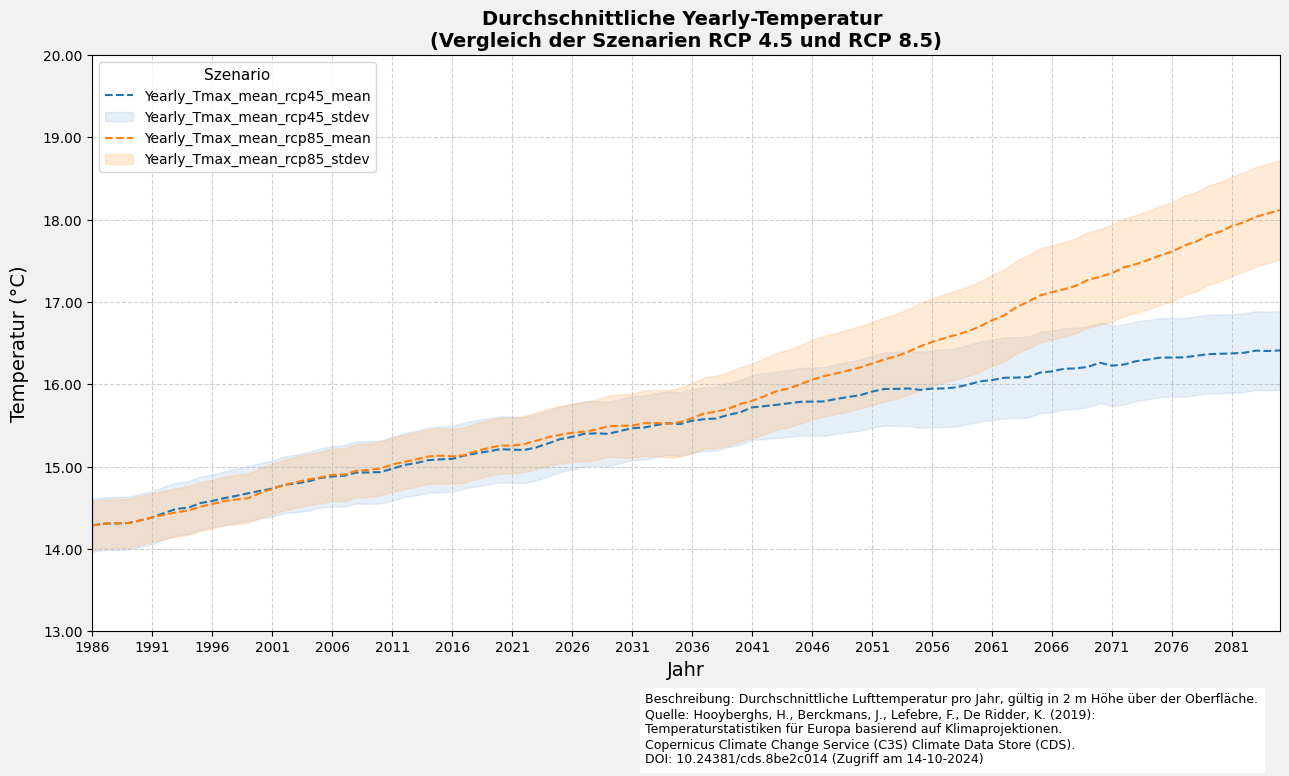

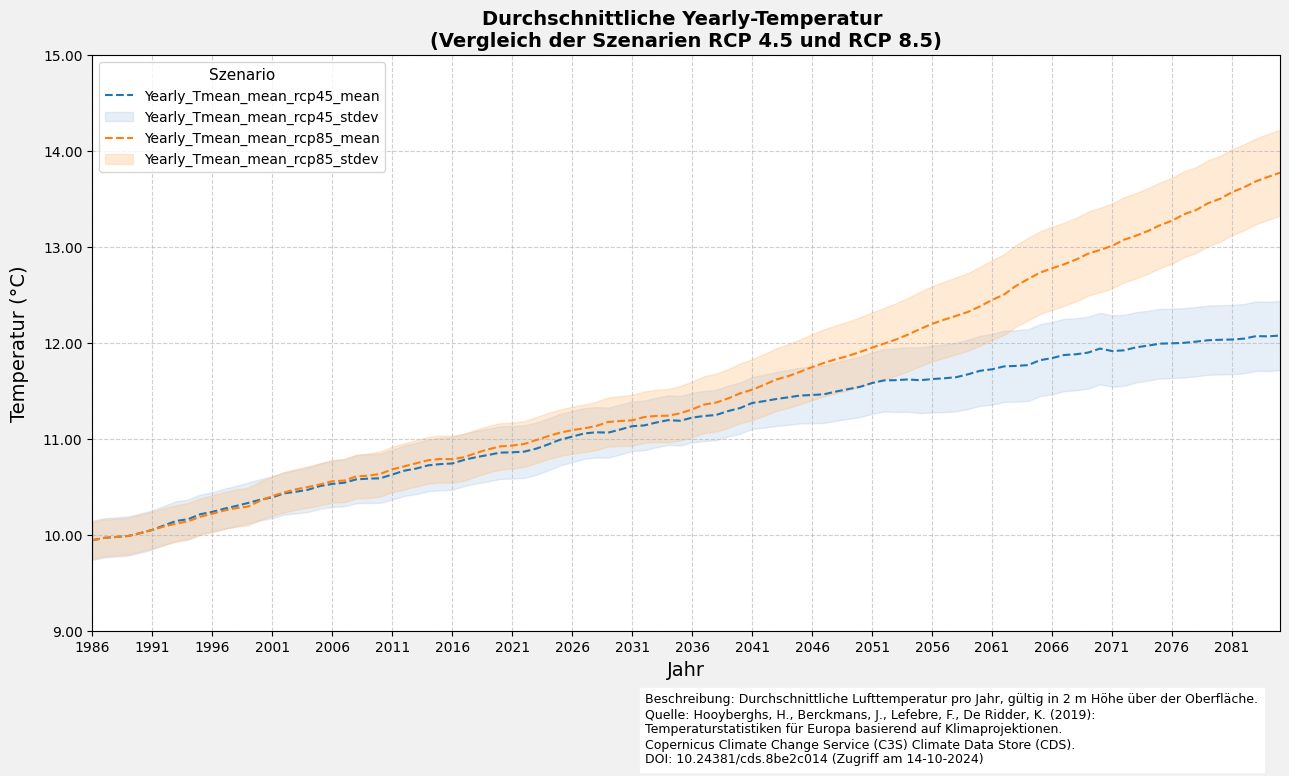

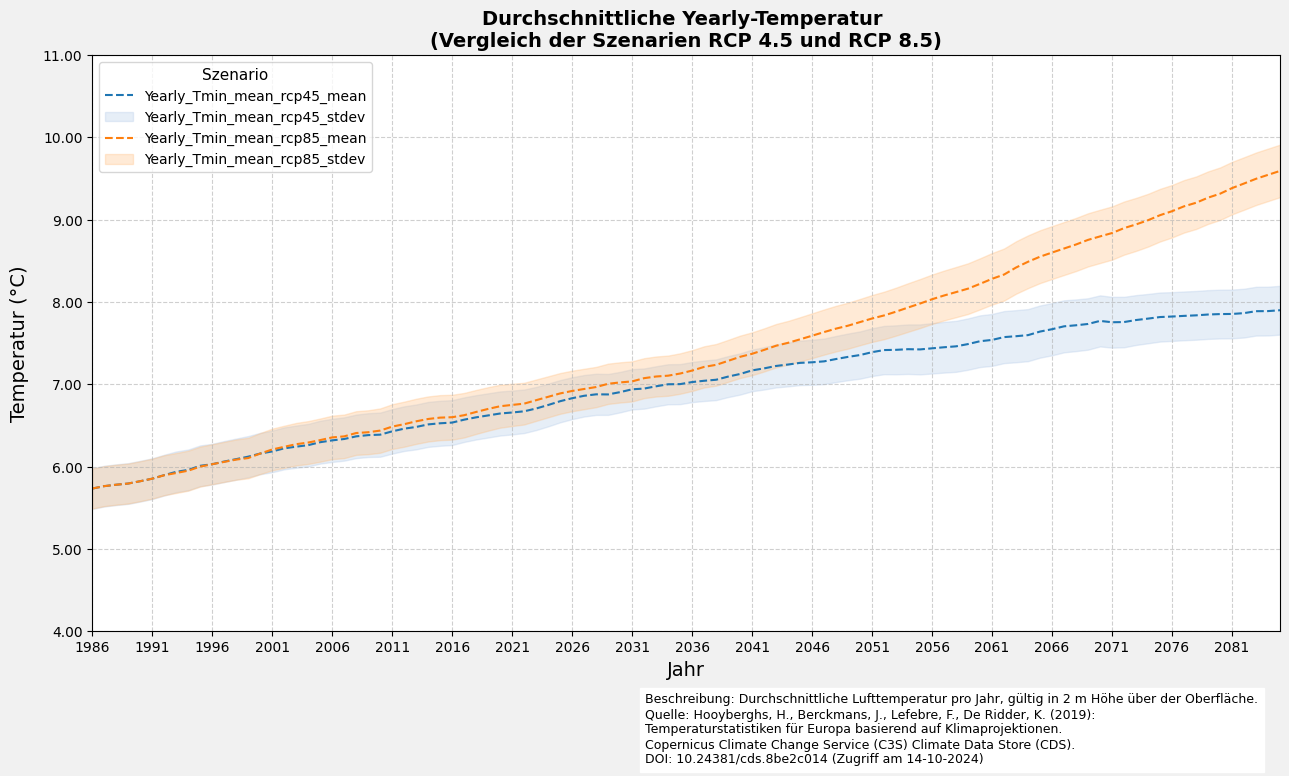

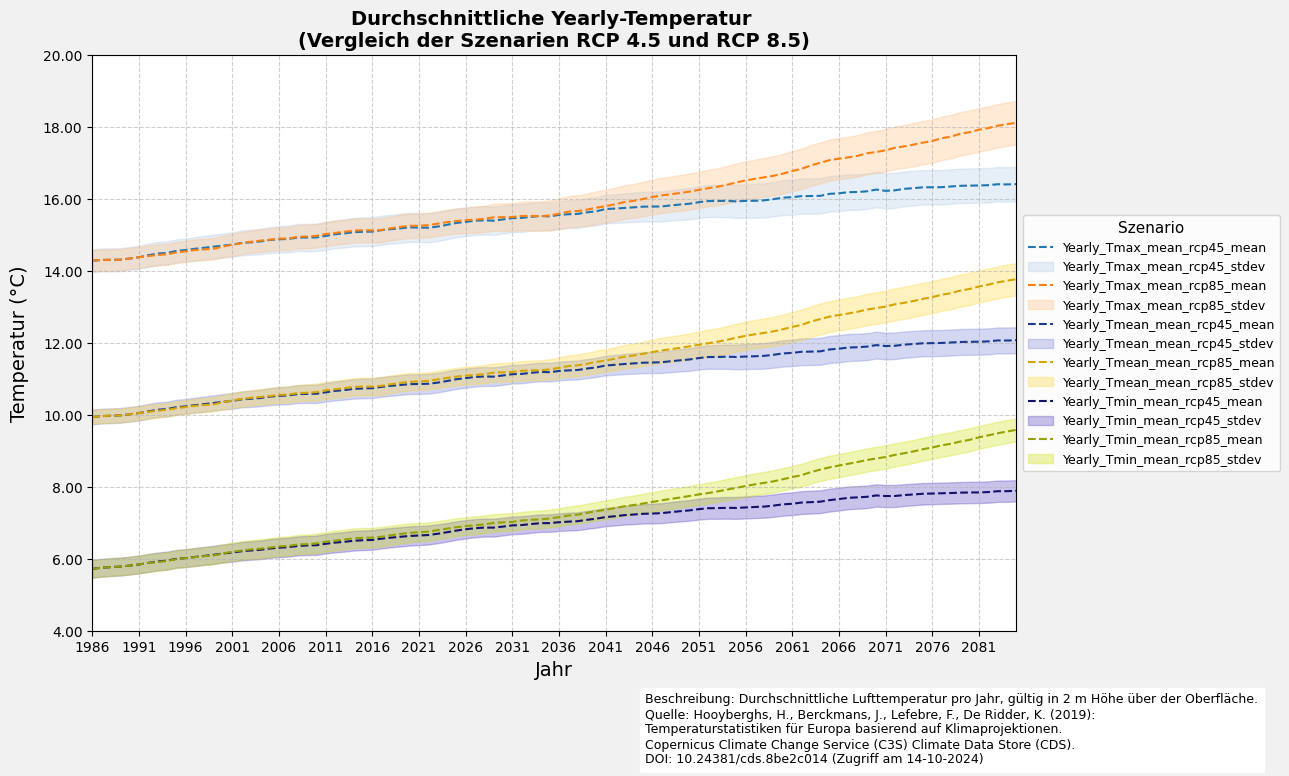

In [25]:
if __name__ == "__main__":
    # Einzelne Datensatzvariable visualisieren
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmax_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmean_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmin_mean"])

    # Mehrere Datensatzvariablen visualisieren
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmax_mean",
                                             f"{nc_files[0]['ds_period']}_Tmean_mean",
                                             f"{nc_files[0]['ds_period']}_Tmin_mean"])
